# Tutorial 21: Sparse Modes<br>
<br>
Tutorial 21: Sparsify DMD modes using dmd_modes_tuner module<br>
Within this tutorial we show how to sparsify DMD modes.
For the modes you can enforce constraints on the real- and imaginary parts.
The example considers video footage of a highway camera.<br>
Using sparse modes, regions of interests e.g. the moving cars can be easily identified.<br>

In [1]:
import os
from pathlib import Path

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from pydmd import DMD
from pydmd.dmd_modes_tuner import BOUND, sparsify_modes

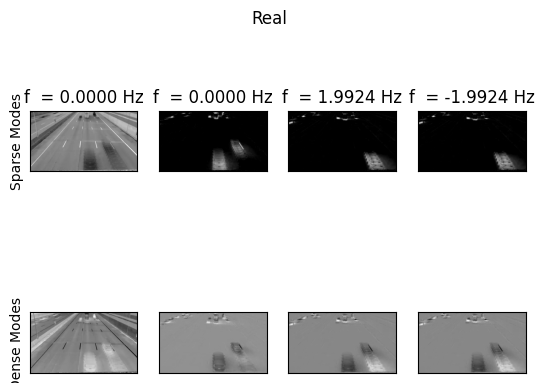

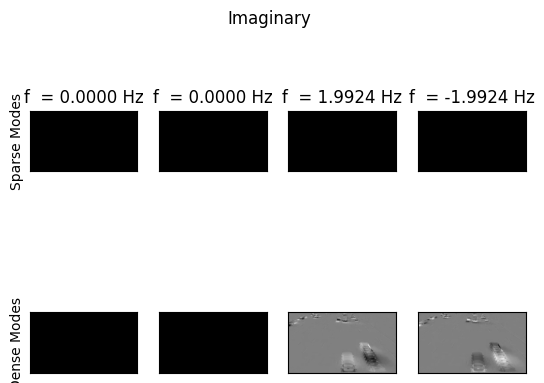

In [5]:
if __name__ == "__main__":
    DIR = os.path.abspath('')
    DIR = os.path.join("video")
    READ_FRAMES = 16
    cap = cv2.VideoCapture(os.path.join(DIR, "cars_lowres.mp4"))
    if not cap.isOpened():
        raise FileNotFoundError(
            os.path.join(DIR, "cars.mp4") + " does not exist!"
        )
    fps = cap.get(cv2.CAP_PROP_FPS)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float `width`
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
    images = np.zeros((int(height), int(width), READ_FRAMES), dtype=np.uint8)
    frames_read = 0
    for i in range(READ_FRAMES):
        if cap.isOpened():
            ret, frame = cap.read()
            if ret:
                images[..., i] = frame[..., 0]
                frames_read += 1
    images = images[..., :frames_read]
    obs = cv2.resize(
        images,
        (int(width), int(height)),
        interpolation=cv2.INTER_CUBIC,
    )
    obs = obs.flatten().reshape((-1, frames_read))
    dmd = DMD()
    dmd.fit(obs[:, :-1], obs[:, 1:])
    omegas = np.log(dmd.eigs) * fps

    # sort continiuous eigenvalues w.r.t. to imaginary part
    sorted_idx = np.argsort(np.abs(omegas.imag))
    time = np.arange(obs.shape[-1]) * np.reciprocal(fps)

    # Setup lower- and upper bounds for real- and imaginary parts of the modes
    bounds_real = BOUND(0.0, None)
    bounds_imag = BOUND(0.0, 0.0)
    sparse_modes, amps = sparsify_modes(
        dmd.modes,
        omegas,
        time,
        obs,
        beta=1e-6,
        bounds_real=bounds_real,
        bounds_imag=bounds_imag,
    )
    sparse_modes = sparse_modes[:, sorted_idx]
    dense_modes = dmd.modes[:, sorted_idx]
    amps = amps[sorted_idx]
    omegas = omegas[sorted_idx]
    fig1, ax1 = plt.subplots(2, sparse_modes.shape[-1])
    fig2, ax2 = plt.subplots(2, sparse_modes.shape[-1])
    for i in range(sparse_modes.shape[-1]):
        sparse_mode_real = sparse_modes[:, i].real.reshape(
            (int(height), int(width))
        )
        dense_mode_real = dense_modes[:, i].real.reshape(
            (int(height), int(width))
        )
        sparse_mode_imag = sparse_modes[:, i].imag.reshape(
            (int(height), int(width))
        )
        dense_mode_imag = dense_modes[:, i].imag.reshape(
            (int(height), int(width))
        )
        ax1[0, i].imshow(sparse_mode_real, cmap="gray")
        ax1[0, i].set_title(f"f  = {omegas[i].imag / 2 / np.pi:.4f} Hz")
        ax1[1, i].imshow(dense_mode_real, cmap="gray")
        ax1[0, i].get_xaxis().set_ticks([])
        ax1[0, i].get_yaxis().set_ticks([])
        ax1[1, i].get_xaxis().set_ticks([])
        ax1[1, i].get_yaxis().set_ticks([])
        ax2[0, i].imshow(sparse_mode_imag, cmap="gray")
        ax2[0, i].set_title(f"f  = {omegas[i].imag / 2 / np.pi:.4f} Hz")
        ax2[1, i].imshow(dense_mode_imag, cmap="gray")
        ax2[0, i].get_xaxis().set_ticks([])
        ax2[0, i].get_yaxis().set_ticks([])
        ax2[1, i].get_xaxis().set_ticks([])
        ax2[1, i].get_yaxis().set_ticks([])
    ax1[0, 0].set_ylabel("Sparse")
    ax1[1, 0].set_ylabel("Dense")
    ax2[0, 0].set_ylabel("Sparse")
    ax2[1, 0].set_ylabel("Dense")
    fig1.suptitle("Modes (Real)")
    fig2.suptitle("Modes (Imaginary)")
    plt.show()